In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

In [2]:
power = pd.read_csv("C:/Users/Bin/Documents/Datasets/EncDec-AD dataset/power_data_labeled.csv",names=["power_demand","label"])

In [3]:
test_set = power.iloc[84*13:,0]
label = power.iloc[84*13:,1]

In [4]:
test_set.shape

(3192,)

# Autoencoder anomaly detection

In [5]:

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time

## Reload power_demand autoencoder from disk

In [6]:
#modelpath_root ="C:/Users/Bin/Desktop/Thesis/tmp/EncDecADModel_online_init/power_demand/Try1_2_40_84/"
modelpath_root =r"C:\Users\Bin\Desktop\Thesis\workspace\1704\model"
modelmeta_p = modelpath_root + r"\Autoencoder_1_40_84_para.ckpt.meta"
step_num = 84
hidden_num = 40
batch_num = 1
elem_num = 1

In [7]:
#test_set_list = [test_set.iloc[:3192,0].as_matrix().reshape(19,2,84,1)[a] for a in range(19)]
test_set_list = [test_set.as_matrix().reshape(38,1,84,1)[a] for a in range(38)]

In [8]:
sess = tf.Session()
saver = tf.train.import_meta_graph(modelmeta_p) # load trained gragh, but without the trained parameters
saver.restore(sess,tf.train.latest_checkpoint(modelpath_root))
graph = tf.get_default_graph()

p_input = graph.get_tensor_by_name("p_input:0")
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)] 
#        p_is_training = tf.placeholder(tf.bool)
p_is_training = graph.get_tensor_by_name("is_training_:0")

input_= tf.transpose(tf.stack(p_inputs), [1, 0, 2])    
output_ = graph.get_tensor_by_name("decoder/output_:0")

tensor_mu = graph.get_tensor_by_name("mu:0")
tensor_sigma = graph.get_tensor_by_name("sigma:0")
tensor_threshold = graph.get_tensor_by_name("threshold:0")

loss_ = graph.get_tensor_by_name("decoder/loss:0")
train_ = graph.get_operation_by_name("cond/train_")

mu = sess.run(tensor_mu)
sigma = sess.run(tensor_sigma)
threshold = sess.run(tensor_threshold)

INFO:tensorflow:Restoring parameters from C:\Users\Bin\Desktop\Thesis\workspace\1704\model\Autoencoder_1_40_84_para.ckpt


In [9]:
print(mu,sigma,threshold)

0.131852 0.131251 0.525604


# Retrain according to performance

## 2. retrain when prediction performance < t

In [10]:
from scipy.spatial.distance import mahalanobis,euclidean
eta = 0.6 #privous parameters plays 60% role during the parameter updating

In [11]:
def scoring(err,mu,sigma,batch_num,step_num):
    scoreBuffer = []
    for window in range(batch_num):
        for t in range(step_num):
            s = euclidean(mu,err[window,t,0])
            scoreBuffer.append(s)
    return scoreBuffer

In [12]:
def update_parameter(errBuffer,mu,sigma,eta,threshold,score,label):       
        tmp_errBuffer = errBuffer[-3:] if len(errBuffer)>3 else errBuffer
        err_vec_array = np.array(tmp_errBuffer)
        # for univariate  data
        __mu = np.mean(err_vec_array.ravel())
        mu = mu*eta + __mu*(1-eta)

        __sigma =np.var(err_vec_array.ravel())
        sigma = __sigma
        
        __thresold = scores.min()
        f = 0
        for t in range(int(scores.min()*100),int(scores.max()*100),5):
            fbeta,_, _ = evaluate(t/100,score,label)
            __thresold = t/100 if fbeta>f else __thresold
            
        threshold = threshold*eta + __thresold*(1-eta)
        return mu,sigma,threshold

In [13]:
def evaluate(threoshld,scores,label):
    beta = 1
    tn = len(set(scores[ scores > threshold].index) & set( label[label=='anomaly'].index))
    fp = len(set(scores[ scores > threshold].index) & set(label[label=='normal'].index))
    fn = len(set(scores[ scores <= threshold].index) & set( label[label=='anomaly'].index))
    tp = len(set(scores[ scores <= threshold].index) & set(label[label=='normal'].index))
    #tp = abnormal_score[abnormal_score>threshold].size
    #fp = abnormal_score.size-tp
    #fn = normal_score[normal_score>threshold].size
    #tn = normal_score.size- fn

    if tp == 0: 
        print("TP is 0.")
        return 0
    

    P = tp/(tp+fp) # reduce the number of didn't detected anomaly
    R = tp/(tp+fn) # recuce the number of normal points that predicted as abnormal
    fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
    print(tp,fp,fn,tn,fbeta,threshold)
    return fbeta,tp, tn

In [24]:
input_buffer = []
output_buffer = []
#anomaly_batches = [0,2,3,18]
anomaly_batches = [3,4,6,25,37]
count = -1
loss_overall = []
err_sum_0 = 0
dataBuffer = []
scoreBuffer = []
scoreWinBuffer = []
a_scoreBuffer = []
n_scoreBuffer = []
errBuffer = []
errSumBuffer = []
fbeta = []
tpBuffer = []
tnBuffer = []
label_list = []
retrainPos = []
thresholdBuffer = []
for data in test_set_list:
    count +=1
    (input_n, output_n) = sess.run([input_, output_], {p_input: data, p_is_training: False})
    
    input_buffer.append(input_n)
    output_buffer.append(output_n)
    
    err = abs(input_n-output_n).reshape(-1,step_num,elem_num)
    err =list(err.ravel())
    errBuffer+=err
    ################
    # offline part #
    ################
#    scores = scoring(err,mu,sigma,batch_num,step_num)
#    scoreBuffer += scores
    scores = pd.Series(np.ones(len(err))-np.array(err))
#    scoreWinBuffer.append(scores[scores > threshold].size)#(max(scores))
    
 
    batch_label = label[count*step_num*batch_num:(count+1)*step_num*batch_num].reset_index(drop=True)
    fpr, tpr, thresholds = metrics.roc_curve(batch_label,scores, pos_label="normal")
    auc = metrics.auc(fpr, tpr)
    print(tpr)
''' 
    label_list.append(batch_label)
    f,tp, tn = evaluate(threshold,scores,batch_label)
    fbeta.append(f)
    tpBuffer.append(tp)
    tnBuffer.append(tn)
    
    if count == 0:
        err_sum_0 = sum(abs(input_n- output_n).ravel())
     
    thresholdBuffer.append(threshold)
    # update parameters, if make wrong prediction
    
    scores = pd.Series(scores)
    

  
    if scores[scores > threshold].size >= 3: # if 3 anomaly point detected within a week, then treat this week as anomaly
        if f < 0.95:
            mu,sigma,threshold = update_parameter(errBuffer,mu,sigma,eta,threshold,scores,label_list[count])
            print("Parameters updated!")
                  
        if count in anomaly_batches:
            print("Correct alarm!!!")
            continue
        else:
            dataBuffer.append(data)
            print("Wrong alarm! Use this batch to update parameters...")
            #mu,sigma,threshold = update_parameter(errBuffer,mu,sigma,eta,threshold,scores)
           
    else:
        if f < 0.95 :
            mu,sigma,threshold = update_parameter(errBuffer,mu,sigma,eta,threshold,scores,label_list[count])
            print("Parameters updated!")
        if count in anomaly_batches:
            print("Miss alarm! Use this batch to update parameters...")       
            #mu,sigma,threshold = update_parameter(errBuffer,mu,sigma,eta,threshold,scores)
            continue
        else:
            print("Correct prediction!!!")
            dataBuffer.append(data)

    # retrain autoencoder, when sum reconstruction error larger than initial max r.error
    
    error_sum = sum(abs(input_n-output_n).ravel())
    
    errSumBuffer.append(error_sum)
    if error_sum >= err_sum_0+0.5 or count ==0:
        retrainPos.append(count)
        print("Retrain at batch number %d\n"%count)
        buffer = dataBuffer[-3:] if len(dataBuffer)>3 else dataBuffer
        loss = []
        for i in range(100):
            ind = np.random.randint(0,len(buffer))
            d = buffer[ind]
            (loss_val, _) = sess.run([loss_, train_], {p_input: d,p_is_training : True})
            loss.append(loss_val)
            print('Retrain-iter %d:' % (i + 1), loss_val)
        loss_overall.append(loss_val)
        pd.Series(loss).plot(title="Loss")
'''

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:563: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:94: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):


[ 0.01190476  1.        ]
[ 0.01190476  1.        ]
[ 0.01190476  1.        ]
[ 0.01388889  0.69444444  0.69444444  0.84722222  0.84722222  0.88888889
  0.88888889  0.93055556  0.93055556  0.98611111  0.98611111  1.          1.        ]
[ 0.01666667  0.75        0.75        0.8         0.8         0.85        0.85
  0.88333333  0.88333333  0.9         0.9         0.91666667  0.91666667
  1.          1.        ]
[ 0.01190476  1.        ]
[ 0.01388889  0.72222222  0.72222222  0.84722222  0.84722222  0.90277778
  0.90277778  1.          1.        ]
[ 0.01190476  1.        ]
[ 0.01190476  1.        ]
[ 0.01190476  1.        ]
[ 0.01190476  1.        ]
[ 0.01190476  1.        ]
[ 0.01190476  1.        ]
[ 0.01190476  1.        ]
[ 0.01190476  1.        ]
[ 0.01190476  1.        ]
[ 0.01190476  1.        ]
[ 0.01190476  1.        ]
[ 0.01190476  1.        ]
[ 0.01190476  1.        ]
[ 0.01190476  1.        ]
[ 0.01190476  1.        ]
[ 0.01190476  1.        ]
[ 0.01190476  1.        ]
[ 0.01

' \n    label_list.append(batch_label)\n    f,tp, tn = evaluate(threshold,scores,batch_label)\n    fbeta.append(f)\n    tpBuffer.append(tp)\n    tnBuffer.append(tn)\n    \n    if count == 0:\n        err_sum_0 = sum(abs(input_n- output_n).ravel())\n     \n    thresholdBuffer.append(threshold)\n    # update parameters, if make wrong prediction\n    \n    scores = pd.Series(scores)\n    \n\n  \n    if scores[scores > threshold].size >= 3: # if 3 anomaly point detected within a week, then treat this week as anomaly\n        if f < 0.95:\n            mu,sigma,threshold = update_parameter(errBuffer,mu,sigma,eta,threshold,scores,label_list[count])\n            print("Parameters updated!")\n                  \n        if count in anomaly_batches:\n            print("Correct alarm!!!")\n            continue\n        else:\n            dataBuffer.append(data)\n            print("Wrong alarm! Use this batch to update parameters...")\n            #mu,sigma,threshold = update_parameter(errBuffer,m

In [16]:
np.array(batch_label)

array(['normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'anomaly', 'anomaly', 'anomaly', 'anomaly', 'anomaly', 'anomaly',
       'anomaly', 'anomaly', 'anomaly', 'anomaly', 'anomaly', 'anomaly',
       'anomaly', 'anomaly', 'anomaly', 'anomaly', 'anomaly', 'anomaly',
       'anomaly', 'anomaly', 'anomaly', 'anomaly', 'anomaly', 'anomaly',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal'], dtype=object)

In [17]:
np.array(err)

array([ 0.03629359,  0.00417043,  0.22280501,  0.00227576,  0.05368751,
        0.01850671,  0.08345205,  0.03045022,  0.17060268,  0.15190153,
        0.03321987,  0.0523541 ,  0.05139928,  0.02018498,  0.24854702,
        0.05319399,  0.08723748,  0.05767298,  0.07731485,  0.04239535,
        0.14292839,  0.10939062,  0.05373827,  0.05550279,  0.01937512,
        0.09435807,  0.19697893,  0.03441882,  0.06939167,  0.070104  ,
        0.10650519,  0.25495034,  0.33649191,  0.36863679,  0.3216064 ,
        0.28028548,  0.34082767,  0.30712751,  0.36456969,  0.31656969,
        0.34740791,  0.3662377 ,  0.31278229,  0.43686256,  0.50339419,
        0.2683661 ,  0.45937514,  0.41981366,  0.44024268,  0.45055681,
        0.42927837,  0.36404979,  0.38783467,  0.33837014,  0.28660515,
        0.18104231,  0.1941382 ,  0.13825038,  0.09070668,  0.00402287,
        0.0282588 ,  0.02199089,  0.03394376,  0.052671  ,  0.02138131,
        0.04675584,  0.01457454,  0.00826541,  0.01193058,  0.04

In [21]:
foo = pd.Series(errBuffer)

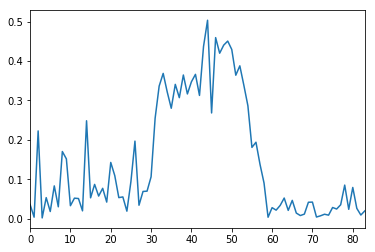

In [35]:
pd.Series(err).plot()

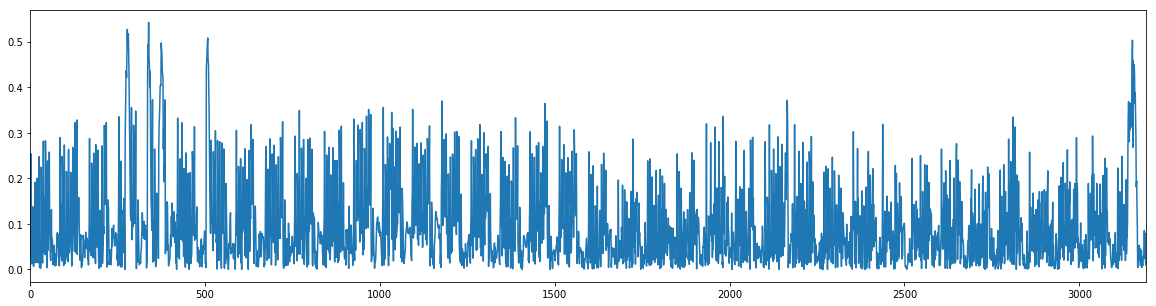

In [34]:
foo.plot()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


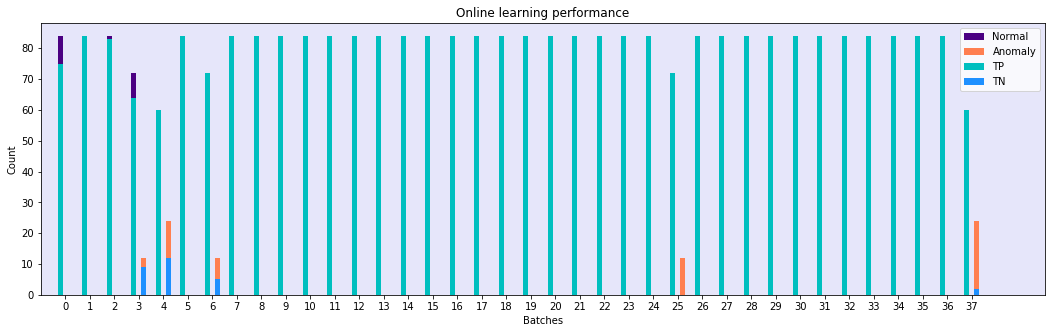

In [15]:
plt.figure(figsize=(18,5))
ax = plt.subplot(111,axisbg='lavender')
x = np.array((range(len(test_set_list))))
nSum = [len(l[l=='normal']) for  l in label_list]
aSum = [len(l[l=='anomaly']) for  l in label_list]
ax.bar(x-0.2,nSum,width=0.2,color='indigo',align='center',label='Normal')
ax.bar(x+0.2,aSum,width=0.2,color='coral',align='center',label='Anomaly')
ax.bar(x-0.2,tpBuffer,width=0.2,color='c',align='center',label='TP')
ax.bar(x+0.2,tnBuffer,width=0.2,color='dodgerblue',align='center',label='TN')


#pd.Series(np.ones(p1_error_n['max'].size)*p1_error_n['max'][0]).plot(label='error.max[0]',color='grey')
#ax.autoscale(tight=True)
plt.legend()
plt.xlim(-1,40)
plt.xlabel("Batches")
plt.ylabel("Count")
plt.title("Online learning performance")

plt.xticks(range(38))
plt.show()

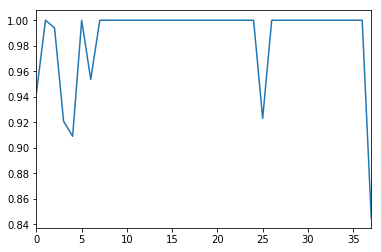

In [16]:
pd.Series(fbeta).plot()

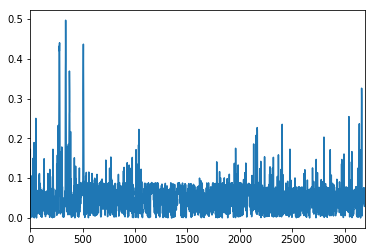

In [17]:
pd.Series(scoreBuffer).plot() # 12

In [18]:
retrainPos

[0, 12, 19, 28]

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


ValueError: shape mismatch: objects cannot be broadcast to a single shape

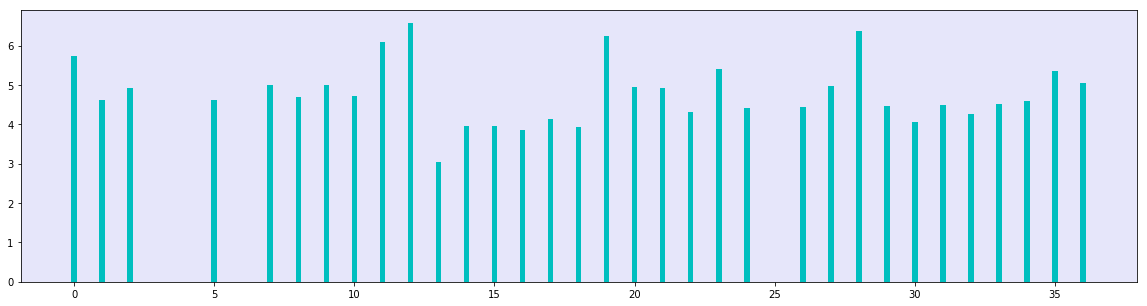

In [19]:
plt.figure(figsize=(20,5))
ax = plt.subplot(111,axisbg='lavender')
x = set(np.array((range(len(test_set_list)))))-set(anomaly_batches)
ax.bar(list(x),errSumBuffer,width=0.2,color='c',align='center',label='Sum of batch reconstruction error')
#ax.bar(anomaly_batches,y,width=0.2,color='deeppink',align='center',label='Sum of batch reconstruction error')
ax.bar(retrainPos,pd.Series(errSumBuffer)[[0,8,16,20,24,32]],width=0.2,color='chocolate',align='center',label="retrain after these batches")
plt.legend()
plt.xlabel("Batch number")
plt.ylabel("Reconstruction error")
plt.title("Sum of batch reconstruction error")
plt.xlim(-1,40)
plt.xticks(range(38))
plt.ylim(0,7.5)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


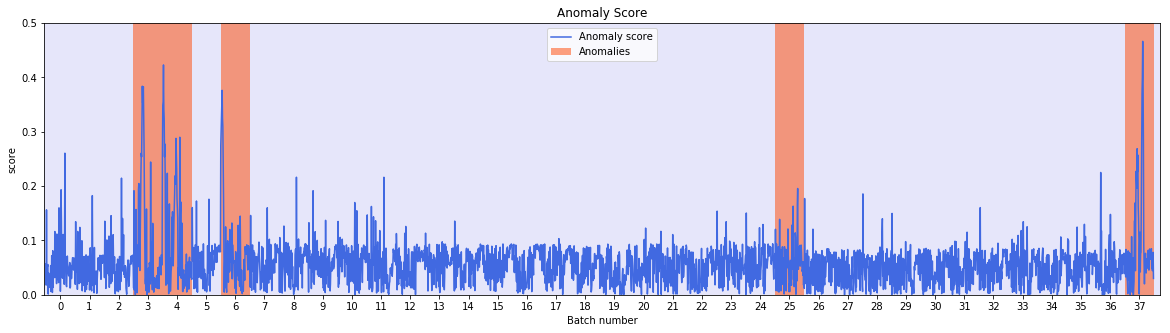

In [39]:
plt.figure(figsize=(20,5))
ax = plt.subplot(111,axisbg='lavender')
x = np.array(range(len(label)))
#xA = x[label=='anomaly']
#yA = pd.Series(scoreBuffer)[xA]
#ax.(x[:],scoreBuffer[:],width=0.2,color='r',align='center',label='Reconstruction error (Normal)')
ax.plot(scoreBuffer[:],color='royalblue',label='Anomaly score')
#ax.bar(xA,yA,width=0.2,color='tomato',align='center',label='Reconstruction error(Anomaly)')

plt.ylim(0,0.5)
plt.xlim(-5,3210)
plt.xlabel("Batch number")
plt.ylabel("score")
plt.title("Anomaly Score")
plt.xticks([84*i+42 for i in range(len(test_set_list)) ],range(len(test_set_list)))
xs = [i*step_num for i in anomaly_batches]
ys = [(i+1)*step_num for i in anomaly_batches]
for i in range(len(xs)):
    plt.axvspan(xs[i], ys[i], facecolor='orangered', alpha=0.5,label='Anomalies')
    if i == 0:
        plt.legend()
        
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


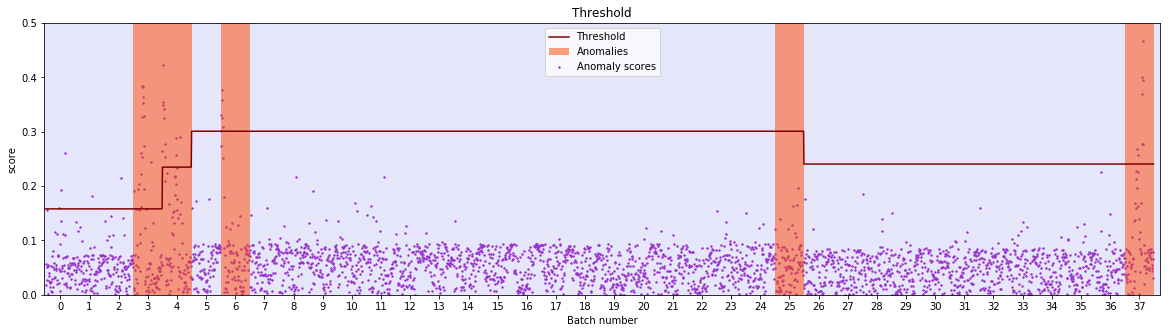

In [40]:
plt.figure(figsize=(20,5))
ax = plt.subplot(111,axisbg='lavender')
x = np.array(range(len(label)))
ax.scatter(x[:],scoreBuffer[:],color='darkorchid',s=2,label='Anomaly scores')
t = np.array([[tmp for _ in range(step_num)] for tmp in thresholdBuffer]).ravel()
ax.plot(t,color='maroon',label='Threshold')

plt.ylim(0,0.5)
plt.xlim(-5,3210)
plt.xlabel("Batch number")
plt.ylabel("score")
plt.title("Threshold")

#xs = [i+1 for i in range(label.size-1) if (label[i] =='normal') & (label[i+1]=='anomaly')]
#ys = [i for i in range(label.size-1) if (label[i] =='anomaly') & (label[i+1]=='normal')]
xs = [i*step_num for i in anomaly_batches]
ys = [(i+1)*step_num for i in anomaly_batches]
for i in range(len(xs)):
    plt.axvspan(xs[i], ys[i], facecolor='orangered', alpha=0.5,label='Anomalies')
    if i == 0:
        plt.legend()
plt.xticks([84*i+42 for i in range(len(test_set_list)) ],range(len(test_set_list)))
plt.show()

In [72]:
foo = pd.Series(np.array(input_buffer).ravel())
bar = pd.Series(np.array(output_buffer).ravel())
foobar = pd.concat((foo,bar),axis=1)

#foobar.to_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/retrain_p1/retraining_if_error_larger_than_error0.csv",header=['input','output'],index=None)

In [23]:
# reconstruction error of normal data(retrain after each batch)

normal =pd.DataFrame( foobar[label[1008+84:]== 'normal'])
abnormal =pd.DataFrame( foobar[label[1008+84:]== 'anomaly'])

error1 = abs( normal[0]- normal[1])
error2 = abs( abnormal[0]- abnormal[1])
error1.plot()
error2.plot()
plt.xlim(-30,error1.size+error2.size)
plt.title("Reconstruction error (retrain_if_error_larger_than_error0)")
print("Normal: Max %.2f, min %.2f, avg %.2f, median %.2f"%(max(error1),min(error1), np.mean(error1),np.median(error1)))
print("Abnormal: Max %.2f, min %.2f, avg %.2f, median %.2f"%(max(error2),min(error2), np.mean(error2),np.median(error2)))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match

In [34]:
# statistical results in batch
normal_batches = [error1[i*(batch_num*step_num):(i+1)*(batch_num*step_num)]for i in range(error1.size//(batch_num*step_num))]
abnormal_batches = [error2[i*(batch_num*step_num):(i+1)*(batch_num*step_num)]for i in range(error2.size//(batch_num*step_num))]

batch_error1  = pd.DataFrame([[max(x),min(x),np.mean(x),np.median(x)] for x in normal_batches])
batch_error2  = pd.DataFrame([[max(y),min(y),np.mean(y),np.median(y)] for y in abnormal_batches])

#batch_error1.to_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/retrain_p1/normal_retraining(batch).csv",header=['max','min','avg','median'],index=None)
#batch_error2.to_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/retrain_p1/abnormal_retraining(batch).csv",header=['max','min','avg','median'],index=None)


In [35]:
error0 =  abs( foobar[0]- foobar[1])
all_batches = [error0[i*(batch_num*step_num):(i+1)*(batch_num*step_num)]for i in range(error0.size//(batch_num*step_num))]
batch_error0  = pd.DataFrame([[max(x),min(x),np.mean(x),np.median(x)] for x in all_batches])
batch_error0.to_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/retrain_p1/all_retraining(batch).csv",header=['max','min','avg','median'],index=None)


In [73]:
data = foobar
#data = pd.read_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/retrain_p1/retraining_if_error_larger_than_error0.csv")

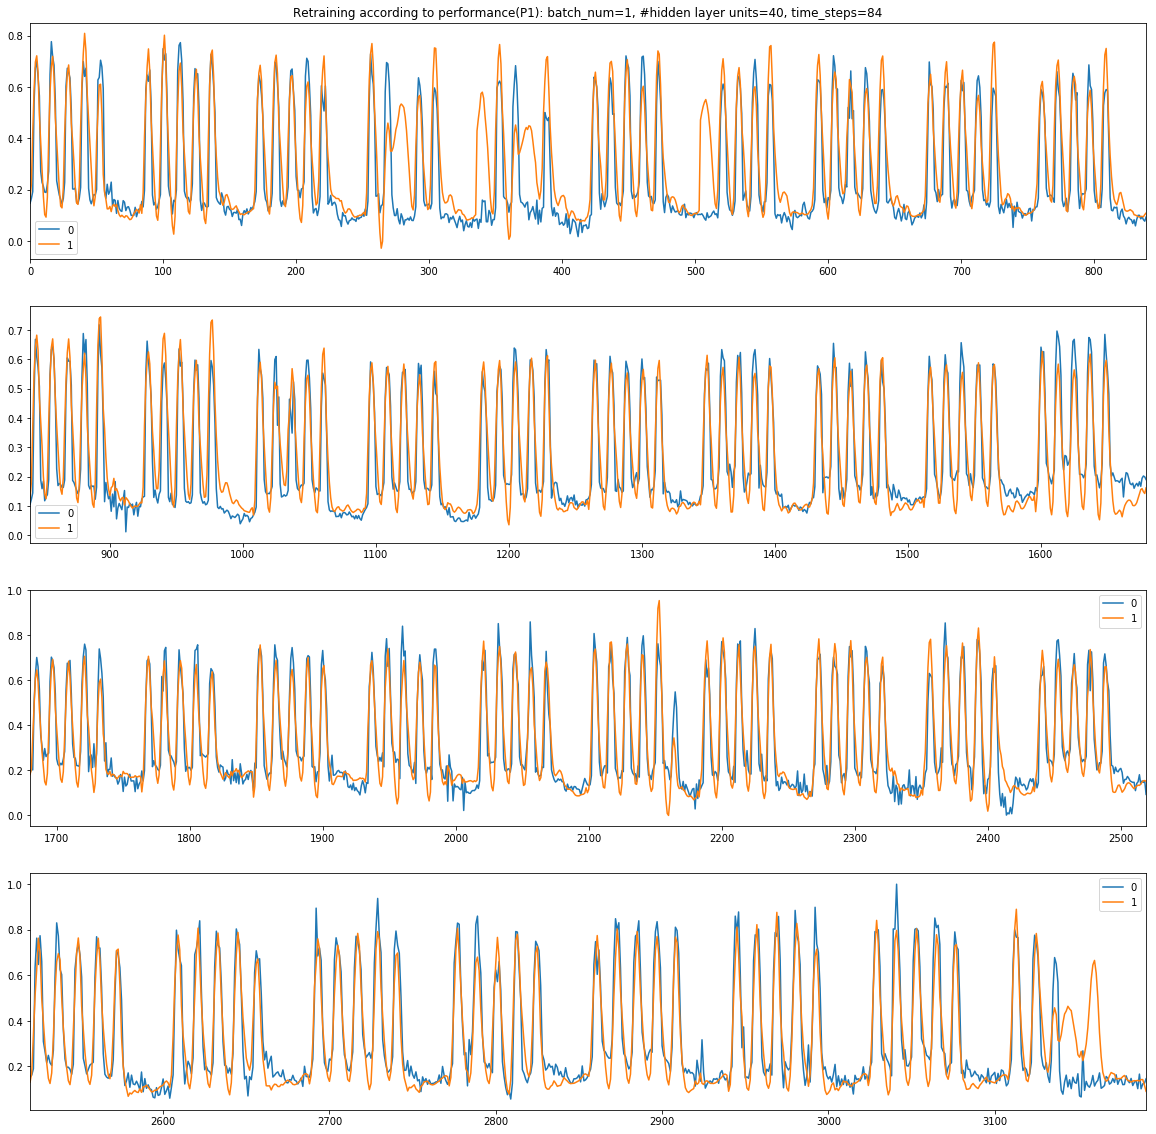

In [74]:
fig, axes = plt.subplots(nrows=4, ncols=1,figsize=(20,20))
axes[0].set_title("Retraining according to performance(P1): batch_num=1, #hidden layer units=40, time_steps=84")
data[:840].plot(ax=axes[0])
data[840*1:840*2].plot(ax=axes[1])
data[840*2:840*3].plot(ax=axes[2])
data[840*3:].plot(ax=axes[3])


(0, 1)

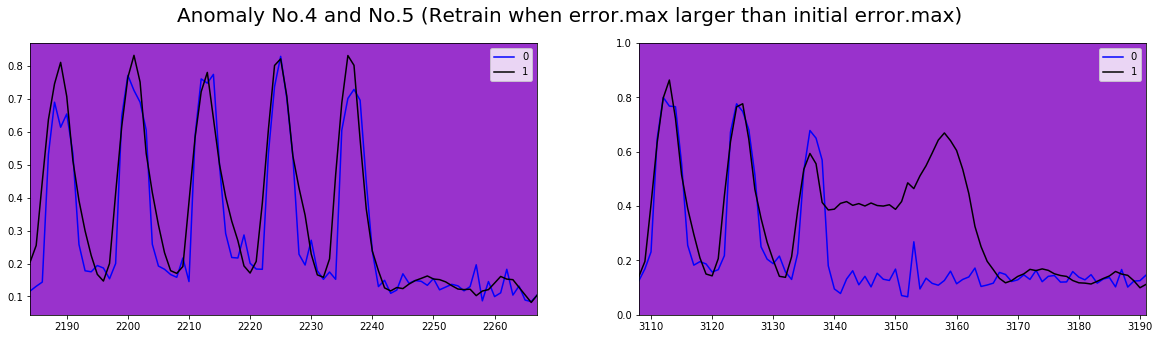

In [42]:
fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2,figsize=(20,5))
plt.suptitle("Anomaly No.4 and No.5 (Retrain when error.max larger than initial error.max)", fontsize=20)
data[84*26:84*27].plot(ax=ax0,color=['blue','black'])
data[-84:].plot(ax=ax1,color=['blue','black'])
ax0.set_facecolor('darkorchid')
ax1.set_facecolor('darkorchid')
plt.ylim(0,1)

(0, 0.8)

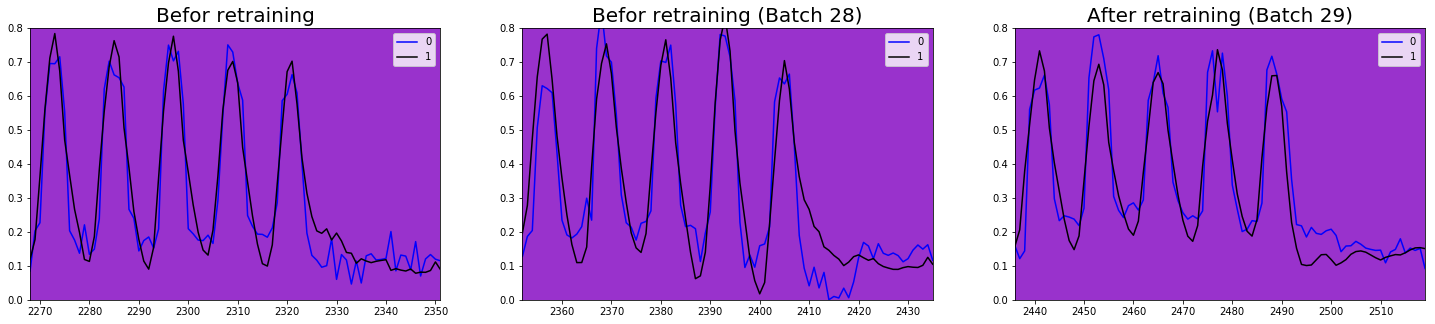

In [87]:
fig, (ax0,ax1,ax2) = plt.subplots(nrows=1, ncols=3,figsize=(25,5))
#plt.suptitle("Befor & after retraining")
rp = 27
data[84*rp:84*(rp+1)].plot(ax=ax0,color=['blue','black'])
data[84*(rp+1):84*(rp+2)].plot(ax=ax1,color=['blue','black'])
data[84*(rp+2):84*(rp+3)].plot(ax=ax2,color=['blue','black'])
ax0.set_facecolor('darkorchid')
ax1.set_facecolor('darkorchid')
ax2.set_facecolor('darkorchid')
ax0.set_title("Befor retraining", fontsize=20)
ax1.set_title("Befor retraining (Batch 28)", fontsize=20)
ax2.set_title("After retraining (Batch 29)", fontsize=20)
ax0.set_ylim(0,0.8)
ax1.set_ylim(0,0.8)
ax2.set_ylim(0,0.8)

In [42]:
foo = pd.read_csv("C:/Users/Bin/Documents/Datasets/EncDec-AD dataset/normal.csv",header=None)
bar = pd.read_csv("C:/Users/Bin/Documents/Datasets/EncDec-AD dataset/abnormal.csv",header=None)


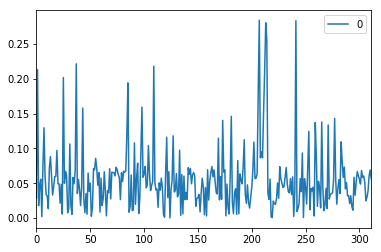

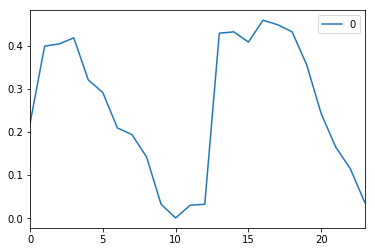

In [43]:
foo.plot()
bar.plot()

In [84]:
upper = max(foo.max()[0],bar.max()[0])
lower = foo.max()[0]
threshold = 0
result = 0
scala = 20
delta = (upper-lower) / scala
candidate = lower
def evaluate(threshold,normal_score,abnormal_score):

    beta = 1
    tp = abnormal_score[abnormal_score>threshold].size
    fp = abnormal_score.size-tp
    fn = normal_score[normal_score>threshold].size
    tn = normal_score.size- fn

    if tp == 0: return 0

    P = tp/(tp+fp) # reduce the number of didn't detected anomaly
    R = tp/(tp+fn) # recuce the number of normal points that predicted as abnormal
    fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
    print(tp,fp,fn,tn,fbeta,threshold)
    return fbeta 

for _ in range(scala):
    r = evaluate(candidate,foo.as_matrix(),bar.as_matrix())
    
    if r > result:
        result = r 
        threshold = candidate
    candidate += delta 

12 12 0 312 0.6666666666666666 0.284109950066
11 13 0 312 0.6285714285714286 0.292871934175
11 13 0 312 0.6285714285714286 0.301633918285
11 13 0 312 0.6285714285714286 0.310395902395
11 13 0 312 0.6285714285714286 0.319157886505
10 14 0 312 0.5882352941176471 0.327919870615
10 14 0 312 0.5882352941176471 0.336681854725
10 14 0 312 0.5882352941176471 0.345443838835
10 14 0 312 0.5882352941176471 0.354205822945
9 15 0 312 0.5454545454545454 0.362967807055
9 15 0 312 0.5454545454545454 0.371729791164
9 15 0 312 0.5454545454545454 0.380491775274
9 15 0 312 0.5454545454545454 0.389253759384
9 15 0 312 0.5454545454545454 0.398015743494
7 17 0 312 0.45161290322580644 0.406777727604
6 18 0 312 0.4 0.415539711714
5 19 0 312 0.3448275862068966 0.424301695824
2 22 0 312 0.15384615384615385 0.433063679934
2 22 0 312 0.15384615384615385 0.441825664043
1 23 0 312 0.07999999999999999 0.450587648153


In [292]:
threshold =0.28410995006561279

In [293]:
mu = 0.0672788

In [294]:
sigma = 0.0032714